# Evaluating Marketing Campaign

### Introduction
This project aims to identify which marketing campaign is the most effective in promoting a new product in a fast-food chain. The success of the campaign is measured through sales. In randomly selected markets, the new item is sold utilizing a different promotion in each location. The first four weeks of sales are recorded. This approach resembles an A/B testing framework, where multiple promotional strategies are compared to determine the most effective one.

### Goal
Develop a strategic plan for selecting the most effective promotions in specific locations to maximize the sales success of the new menu item.

### Data
* *MarketID:* unique identifier for market
* *MarketSize:* size of market area by sales
* *LocationID:* unique identifier for store location
* *AgeOfStore:* age of store in years
* *week:* one of four weeks when the promotions were run
* *SalesInThousands:* sales amount for a specific *LocationID, Promotion,* and *week*

### Statistical Methods
* ANOVA (Analysis of Variance): statistical test used to analyse the difference between the means of more than two groups
* Shapiro-Wilk Test: hypothesis test that evaluates whether a dataset is normally distributed
* Levene test: inferential statistic used to assess the equality of variances across two or more groups
* Kruskal-Wallis test: non-parametric statistical test to determine if there are statistically significant differences between two or more groups
* Dunn's test: post-hoc test following the Kruskal-Wallis test, used for pairwise comparisons to determine if specific pairs of groups differ significantly from each other
* t-test: parametric test used to evaluate differences between the means of two groups when the data follows a normal distribution
* Man-Whitney U test: non-parametric statistical test to determine if there are statistically significant differences between two groups


### Summary of Results
The findings indicate that promotions 1 and 3 resulted in significantly higher sales than promotion 2. Further analysis of promotions 1 and 3 across different market sizes revealed that promotion 1 significantly outperformed promotion 3 in medium-sized markets. However, no significant differences in sales were observed between promotions 1 and 3 in small and large markets. Based on these results, I recommend discontinuing promotion 2 entirely. Promotion 1 should be prioritised in medium markets, and the choice between promotions 1 and 3 in small and large markets should be guided by cost efficiency.

## Dependencies
Import necessary libraries.

In [147]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, levene, kruskal, ttest_ind, mannwhitneyu
import scikit_posthocs as sp
import statsmodels.api as sm

## Data

In [148]:
fastfood = pd.read_csv('WA_Marketing-Campaign.csv')

In [149]:
fastfood

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [150]:
# Checking column data types
column_names = fastfood.dtypes.reset_index()
column_names.columns = ['Column Names', 'Data Type']
column_names = tabulate(column_names, headers='keys', tablefmt='pretty')
print(column_names)

+---+------------------+-----------+
|   |   Column Names   | Data Type |
+---+------------------+-----------+
| 0 |     MarketID     |   int64   |
| 1 |    MarketSize    |  object   |
| 2 |    LocationID    |   int64   |
| 3 |    AgeOfStore    |   int64   |
| 4 |    Promotion     |   int64   |
| 5 |       week       |   int64   |
| 6 | SalesInThousands |  float64  |
+---+------------------+-----------+


In [151]:
# Checking for missing values
fastfood.isnull().mean()

MarketID            0.0
MarketSize          0.0
LocationID          0.0
AgeOfStore          0.0
Promotion           0.0
week                0.0
SalesInThousands    0.0
dtype: float64

In [152]:
# Check for duplicates with the same location and week
duplicates = fastfood[fastfood.duplicated(subset=['LocationID', 'week'], keep=False)]
duplicates.shape

(0, 7)

In [153]:
# Setting order of promotions so plots follow consistent order
promotion_order = [1, 2, 3]
fastfood['Promotion'] = pd.Categorical(fastfood['Promotion'], categories=promotion_order, ordered=True)

## Data Visualisation & Checking Distributions

Create exploratory data visualisations to understand the distributions of the different variables in this dataset.

In [154]:
# Make sure distribution of promotions is even
fastfood['Promotion'].value_counts(sort=False) / fastfood.shape[0]

1    0.313869
2    0.343066
3    0.343066
Name: Promotion, dtype: float64

<Figure size 300x300 with 0 Axes>

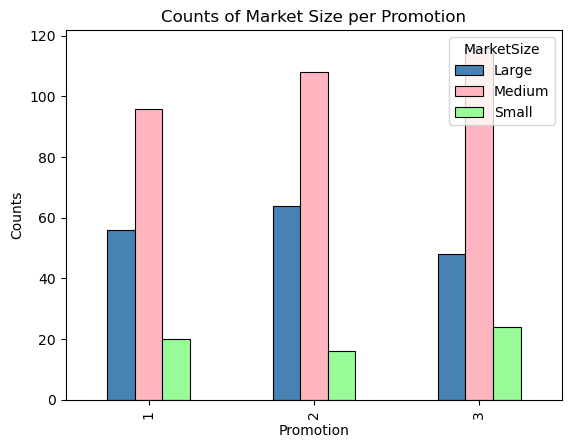

In [155]:
# Distribution of market size per promotion
counts = fastfood.groupby(['Promotion', 'MarketSize']).size().unstack()
custom_colors = ['#4682B4', '#FFB6C1', '#98FB98']
plt.figure(figsize=(3,3))
counts.plot(kind='bar', color=custom_colors, edgecolor='black', linewidth=.8)
plt.title('Counts of Market Size per Promotion')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Store Age Distribution by Promotion')

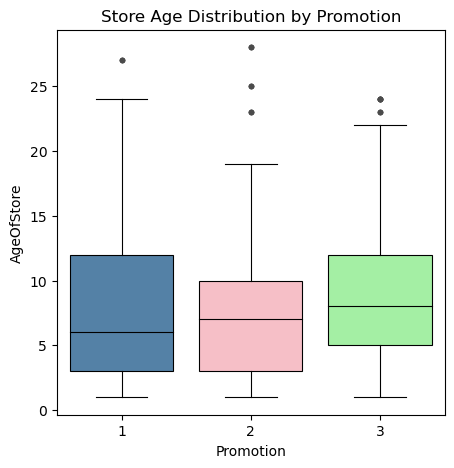

In [156]:
# Distribution of age of store per promotion
plt.figure(figsize=(5,5))
palette = {1: '#4682B4', 2: '#FFB6C1', 3: '#98FB98'}
sns.boxplot(x='Promotion', 
            y='AgeOfStore', 
            data=fastfood, 
            palette=palette,
            boxprops=dict(edgecolor='black', linewidth=0.8),
            whiskerprops=dict(color='black', linewidth=0.8),
            capprops=dict(color='black', linewidth=0.8),
            medianprops=dict(color='black', linewidth=0.8),
            flierprops=dict(marker='o', color='black', markersize=3))
plt.title('Store Age Distribution by Promotion')

Text(0, 0.5, 'Counts')

<Figure size 500x500 with 0 Axes>

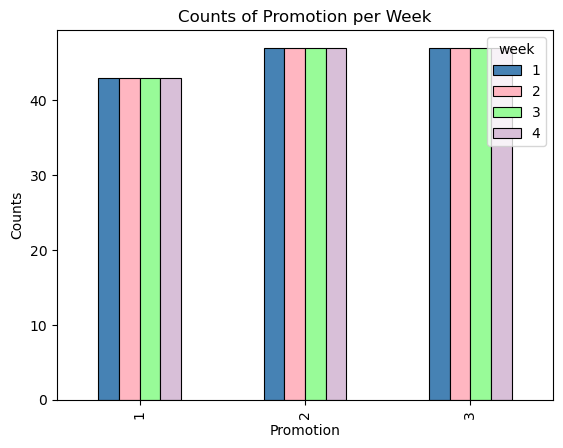

In [157]:
# Distribution of week per promotion
counts = fastfood.groupby(['Promotion', 'week']).size().unstack()
custom_colors = ['#4682B4', '#FFB6C1', '#98FB98', '#D8BFD8']
plt.figure(figsize=(5,5))
counts.plot(kind='bar', color=custom_colors, edgecolor='black', linewidth=0.8)
plt.title('Counts of Promotion per Week')
plt.ylabel('Counts')

In [158]:
def boxplot(data, title, palette, ax=None):
    """
    Create boxplots to compare sales distributions between promotions.
    """
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='Promotion', 
            y='SalesInThousands', 
            data=data, 
            palette=palette,
            order=palette.keys(),
            boxprops=dict(edgecolor='black', linewidth=0.8),
            whiskerprops=dict(color='black', linewidth=0.8),
            capprops=dict(color='black', linewidth=0.8),
            medianprops=dict(color='black', linewidth=0.8),
            flierprops=dict(marker='o', color='black', markersize=3),
            ax=ax)
    ax.set_title(title)

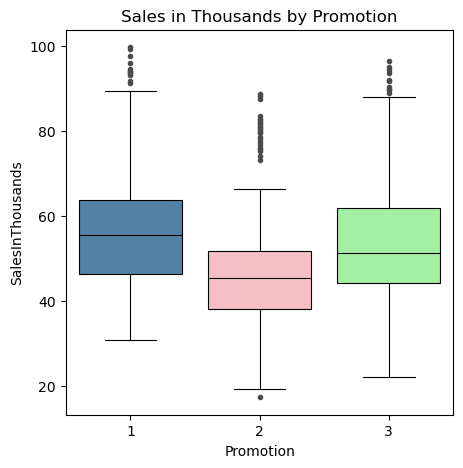

In [159]:
plt.figure(figsize=(5,5))
my_palette = {1: '#4682B4', 2: '#FFB6C1', 3: '#98FB98'}
boxplot(fastfood, 'Sales in Thousands by Promotion', my_palette)

In [160]:
def overlapping_histogram(data, color):
    """
    Plot overlapping histograms for sales distributions by promotion.
    """
    # plt.figure(figsize=(7,4))
    order = data['Promotion'].cat.categories.intersection(data['Promotion'].unique())
    for i, promo in enumerate(order):
        sns.histplot(data[data['Promotion'] == promo],
                     x='SalesInThousands',
                     kde=True,  
                     color=color[i],
                     label=f'Promotion {promo}',
                     stat='density',
                     alpha=0.6)
        plt.title('Overlapping Sales Distribution by Promotion')
        plt.xlabel('Sales in Thousands')
        plt.ylabel('Density')
        plt.legend(title='Promotion')

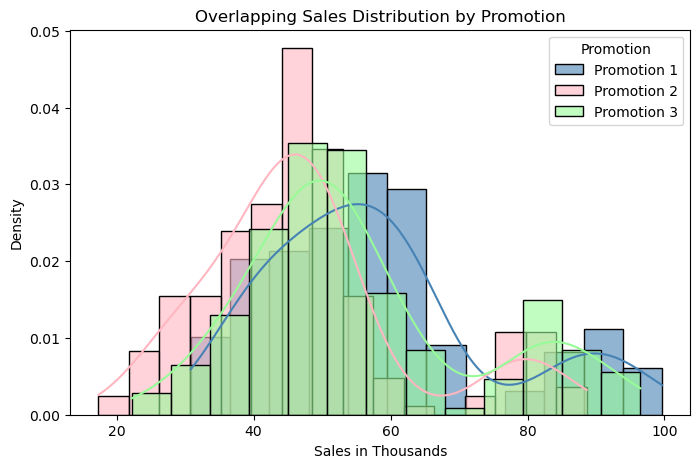

In [161]:
plt.figure(figsize=(8,5))
color = ['#4682B4', '#FFB6C1', '#98FB98']
overlapping_histogram(fastfood, color)

The sales distribution per promotion is not normal. The distributions are slightly skewed to the right and appear to be bimodal.

In [162]:
# Summary statistics of promotion and sales
summary_stats = fastfood.groupby('Promotion')['SalesInThousands'].describe()
print(summary_stats)

           count       mean        std    min      25%     50%      75%    max
Promotion                                                                     
1          172.0  58.099012  16.553782  30.81  46.3525  55.385  63.6175  99.65
2          188.0  47.329415  15.108955  17.34  38.1700  45.385  51.7450  88.64
3          188.0  55.364468  16.766231  22.18  44.1975  51.165  61.7325  96.48


## Assumptions

To assess the success of different promotions, my first thought is to use an ANOVA (Analysis of Variance) test. ANOVA relies on three key assumptions for valid results - the observations must be independent, the residuals should follow a normal distribution, and there must be homogeneity of variance (homoscedasticity). I already know that the sales in one location do not influence or correlate with the sales in another location. Therefore, I can move on to testing for normality and homoscedasticity.

#### Normality: Q-Q Plot
ANOVA assumes the normality of the residuals (errors) should be normally distributed. To test for this, I fit an ANOVA model and inspected a Q-Q plot of the residuals.

In [163]:
def qqplot_residuals(data, x, y):
    """
    Generate a Q-Q plot of residuals from an ANOVA model to assess normality.

    Returns:
        Residuals from the fitted ANOVA model.
    """
    model = sm.formula.ols('SalesInThousands ~ Promotion', data = data).fit()
    residuals = model.resid
    fig, ax = plt.subplots(figsize=(4, 4))
    stats.probplot(residuals, dist = 'norm', plot = ax)
    for line in ax.get_lines():
        line.set_markersize(3)
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    return residuals

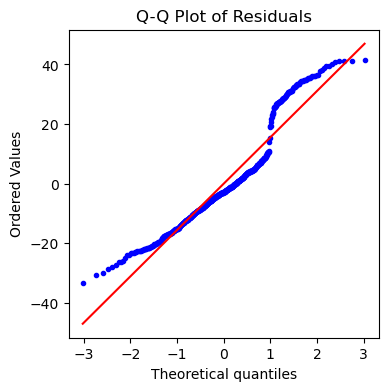

In [164]:
residuals = qqplot_residuals(fastfood, 'Promotion', 'SalesInThousands')

#### Normality: Shapiro-Wilk test
In addition to the Q-Q plot, I performed a Shapiro-Wilk test on the residuals. This is a hypothesis test that evaluates whether a dataset is normally distributed.
* H0: The residuals from the ANOVA model follow a normal distribution
* H1: The residuals from the ANOVA model do not follow a normal distribution

In [165]:
def shapiro_func(data):
    """
    Perform Shapiro-Wilk test to assess the normality of the data.
    """
    print('Shapiro-Wilk Test')
    stat, p = shapiro(data)
    print(f'   W-statistic: {stat}')
    print(f'   p-value: {p} (>0.05)')
    if p > 0.05:
        print(f'Data appears to be normally distributed - normality assumption is met')
    else:
        print(f'Data does NOT appear normally distributed - normality assumption vioated')

In [166]:
shapiro_func(residuals)

Shapiro-Wilk Test
   W-statistic: 0.9220818877220154
   p-value: 3.1545386310101865e-16 (>0.05)
Data does NOT appear normally distributed - normality assumption vioated


#### Homoscedasticity: Levene's test
ANOVA assumes that the variances within each group are approximately equal. To test for this, I used Levene's test which assesses whether the variances across groups are significantly different.
* H0: The variances of sales between the different promotions are equal
* H1: At least one promotion has a significantly different variance in sales compared to the others

In [167]:
def levenes_func(data):
    """
    Perform Leven's test to assess the homogeneity of variances across groups.
    """
    print("Levene's Test")
    promotions = data['Promotion'].unique()
    promotion_groups = [data[data['Promotion'] == promo]['SalesInThousands'] for promo in promotions]
    ## list of groups, where each group contains sales data for a different promotion
    stat, p = levene(*promotion_groups)
    print(f'   F Statistic: {stat}')
    print(f'   p-value: {p} (>0.05)')
    if p > 0.05:
        print(f'Variances appear homogeneous across groups - homogeneity assumption is met')
    else:
        print('Variances do NOT appeaer homogeneous across groups - homogeneity assumption violated')

In [168]:
levenes_func(fastfood)

Levene's Test
   F Statistic: 1.2696787527507418
   p-value: 0.2817514565692118 (>0.05)
Variances appear homogeneous across groups - homogeneity assumption is met


#### Assumption Conclusion
Because the normality assumption is not met, I cannot use ANOVA to test the difference in sales means across promotions. Because the homogeneity assumption is met, I can instead use the Kruskal-Wallis test.

## Kruskal-Wallis Test
This is a non-parametric alternative to ANOVA that is used to compare the medians between independent groups, without assuming a normal distribution.
* H0: There is not a significant difference in median sales between promotions
* H1: There is a significant difference in median sales between promotions

In [169]:
# Kruskal-Wallis test
promotions = fastfood['Promotion'].unique()
promotion_groups = [fastfood[fastfood['Promotion'] == promo]['SalesInThousands'] for promo in promotions]
stat, p_value = kruskal(*promotion_groups)
print('Kruskal-Wallis Test')
print(f'   p-value: {p_value}')
if p_value > 0.05:
    print('No statistically significant difference between groups')
else:
    print('Statistically significant difference between groups')

Kruskal-Wallis Test
   p-value: 2.6741866266697816e-12
Statistically significant difference between groups


This indicates that the sales do differ significantly between the three different promotions. However, the Kruskal-Wallis test does not specify which groups differ from each other.

## Dunn's Test
As a post-hoc analysis, I will use Dunn's test to see which promotions show significant differences in sales.
* H0: There is no significant difference in median sales between promotions
* H1: There is a significant difference in median sales between promotions

In [170]:
# Perform Dunn's test
dunn_results = sp.posthoc_dunn(fastfood, 
                               val_col='SalesInThousands', 
                               group_col='Promotion', 
                               p_adjust='bonferroni')

In [171]:
# Print out results
promotion_mapping = {1: 'Promotion 1', 2: 'Promotion 2', 3: 'Promotion 3'}
promotion_array = np.array([promotion_mapping[i] for i in fastfood['Promotion'].unique()])
dunn_results.index = promotion_array
dunn_results.columns = promotion_array
dunn_results

,Promotion 3,Promotion 2,Promotion 1
Promotion 3,1.000000e+00,6.461842e-12,1.458660e-01
Promotion 2,6.461842e-12,1.000000e+00,7.083069e-07
Promotion 1,1.458660e-01,7.083069e-07,1.000000e+00


- Promotions 1 and 2 have sigificant differences between each other (7.08e-07 < 0.05)
- Promotions 2 and 3 have significant differences between each other (6.46e-12 < 0.05)  
- Promotions 1 and 3 do not have significant differences between each other (0.146 > 0.05)

In [172]:
# Summary statistics of promotion and sales
summary_stats = fastfood.groupby('Promotion')['SalesInThousands'].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


Promotion 2 clearly brought in the lowest amount of sales. Through Dunn's test, we can see that promotion 2 has brought in a significantly different amount of sales compared to promotions 1 and 2.

## Sub-Analyses
Because promotions 1 and 3 clearly perform better, is there a difference between how the promotions perform in different market sizes?

In [173]:
# Investigate different promotions and market sizes
fastfood_subset = fastfood[fastfood['Promotion'].isin([1, 3])].copy()
fastfood_subset['Promotion'] = fastfood_subset['Promotion'].cat.remove_unused_categories()
market_size = fastfood_subset.groupby(['Promotion', 'MarketSize']).agg(
    Counts = ('SalesInThousands', 'size'),
    Mean_Sales = ('SalesInThousands', 'mean')
).reset_index()
market_size['Proportion'] = market_size['Counts'] / fastfood.shape[0]
market_size

,Promotion,MarketSize,Counts,Mean_Sales,Proportion
0,1,Large,56,75.235893,0.102190
1,1,Medium,96,47.672604,0.175182
2,1,Small,20,60.162500,0.036496
3,3,Large,48,77.203958,0.087591
4,3,Medium,116,45.468879,0.211679
5,3,Small,24,59.514167,0.043796


In [174]:
# Making separate datasets for each market size for only promotions 1 and 3
large = fastfood_subset.loc[fastfood_subset['MarketSize'] == 'Large']
medium = fastfood_subset.loc[fastfood_subset['MarketSize'] == 'Medium']
small = fastfood_subset.loc[fastfood_subset['MarketSize'] == 'Small']

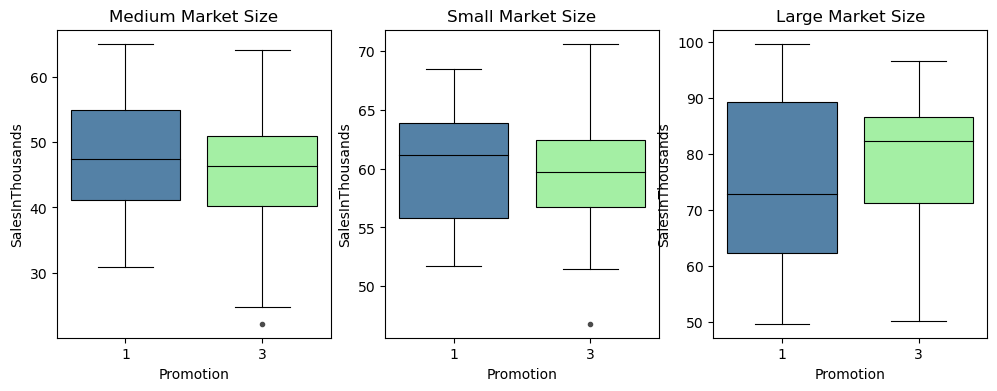

In [175]:
# Distribution of sales per promotion per market size
fig, axes = plt.subplots(1, 3, figsize=(12,4))
my_palette = {1: '#4682B4', 3: '#98FB98'}
for i, marketsize in enumerate(promo1_3['MarketSize'].unique()):
    ax = axes[i]
    subset = promo1_3[promo1_3['MarketSize'] == marketsize]
    boxplot(subset, f'{marketsize} Market Size', my_palette, ax)

### Large Market

In [176]:
# Distribution of sales across promotions for large markets
median = large.groupby('Promotion')['SalesInThousands'].median()
summary_stats = large.groupby('Promotion')['SalesInThousands'].describe()
summary_stats['median'] = median
summary_stats

,count,mean,std,min,25%,50%,75%,max,median
Promotion,,,,,,,,,
1,56.0,75.235893,15.497497,49.62,62.2350,72.835,89.2675,99.65,72.835
3,48.0,77.203958,14.400304,50.05,71.1225,82.345,86.5300,96.48,82.345


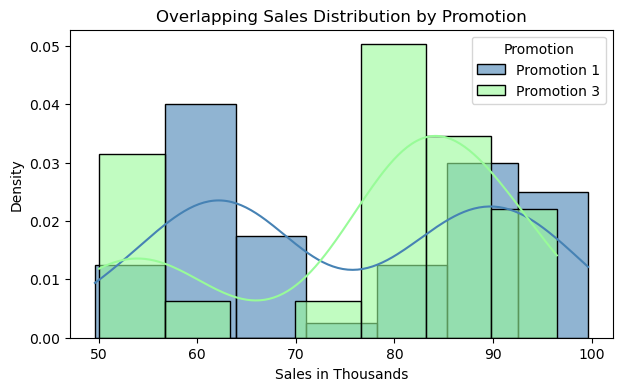

In [177]:
# Distribution of sales per promotion for large markets
plt.figure(figsize=(7,4))
overlapping_histogram(large, ['#4682B4', '#98FB98'])
plt.show()

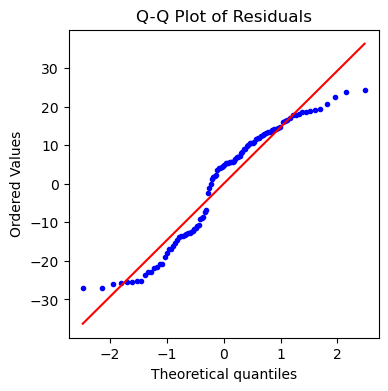

In [178]:
# Q-Q plo,residuals from ANOVA model
residuals = qqplot_residuals(large, 'Promotion', 'SalesInThousands')

In [179]:
# Shapiro-Wilk test (normality)
shapiro_func(residuals)

Shapiro-Wilk Test
   W-statistic: 0.9273124933242798
   p-value: 2.488524478394538e-05 (>0.05)
Data does NOT appear normally distributed - normality assumption vioated


In [180]:
# Levene's test (homoscedasticity)
levenes_func(large)

Levene's Test
   F Statistic: 5.385970343904218
   p-value: 0.022289657678924324 (>0.05)
Variances do NOT appeaer homogeneous across groups - homogeneity assumption violated


Because the normality and homogeneity assumptions are not met and I am only comparing two groups, I will use the Man-Whitney U test. It is a non-parametric test that compares the medians of two different groups.

#### Comparing Two Groups: Welch's t-test and Mann-Whitney U Test 
To evaluate whether there is a statistically significant difference between the means of two groups, I performed both a Welch's t-test and Mann-Whitney U test. The choice of test depends on whether the assumption of normality and homogeneity of variance is met.
* Student's t-test: a parametric test used when data follows a normal distribution and assumes equal variance between groups
    * H0: The mean sales between the promotions are equal
    * H1: The mean sales between the promotions are not equal
* Welch's t-test: a parametric test used when the data follows a normal distribution but does not assume equal variances between the groups
    * H0: The mean sales between the promotions are equal
    * H1: The mean sales between the promotions are not equal
* Mann-Whitney U test: a non-parametric alternative used when the normality assumption is not met
    * H0: The distribution of sales between the two promotions is equal
    * H1: The distribution of sales between the two promotions is not equal

In [181]:
def compare_two_means(data, group_col, value_col, group1, group2, test):
    """
    Perform a statistical test to compare the means or distributions of two groups.
    """
    group1_data = data.loc[data[group_col] == group1, value_col]
    group2_data = data.loc[data[group_col] == group2, value_col]
    
    if test == 'Mann-Whitney U':
        stat, p = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f'Mann-Whitney U test result for Promotion {group1} vs {group2}')
        print(f'U-Statistic: {stat}')
        print(f'p-value: {p}')
    if test == "Student's t-test":
        stat, p = ttest_ind(group1_data, group2_data, equal_var=True)
        print(f'Independent t-test result for Promotion {group1} vs {group2}')
        print(f'T-Statistic: {stat}')
        print(f'p-value: {p}')
    if test == "Welch's t-test":
        stat, p = ttest_ind(group1_data, group2_data, equal_var=False)
        print(f'Independent t-test result for Promotion {group1} vs {group2}')
        print(f'T-Statistic: {stat}')
        print(f'p-value: {p}')
    
    if p > 0.05:
        print('No significant difference between the two groups.')
    else:
        print("Significant difference between the two groups.")

In [182]:
compare_two_means(large, 'Promotion', 'SalesInThousands', 1, 3, 'Mann-Whitney U')

Mann-Whitney U test result for Promotion 1 vs 3
U-Statistic: 1349.0
p-value: 0.9765916069490451
No significant difference between the two groups.


### Medium Market

In [183]:
# Distribution of sales across promotions for medium markets
median = medium.groupby('Promotion')['SalesInThousands'].median()
summary_stats = medium.groupby('Promotion')['SalesInThousands'].describe()
summary_stats['median'] = median
summary_stats

,count,mean,std,min,25%,50%,75%,max,median
Promotion,,,,,,,,,
1,96.0,47.672604,8.067331,30.81,41.215,47.425,54.99,65.11,47.425
3,116.0,45.468879,8.091366,22.18,40.280,46.295,51.03,64.14,46.295


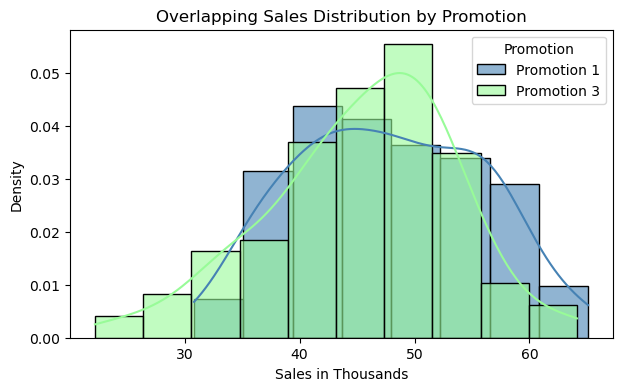

In [184]:
# Distribution of sales per promotion for medium markets
plt.figure(figsize=(7,4))
overlapping_histogram(medium, ['#4682B4', '#98FB98'])
plt.show()

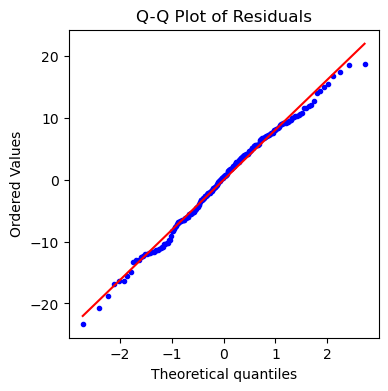

In [185]:
# Q-Q plot, residuals from ANOVA model
residuals = qqplot_residuals(medium, 'Promotion', 'SalesInThousands')

In [186]:
# Shapiro-Wilk test (normality)
shapiro_func(residuals)

Shapiro-Wilk Test
   W-statistic: 0.9919666647911072
   p-value: 0.2963274121284485 (>0.05)
Data appears to be normally distributed - normality assumption is met


In [187]:
# Levene's test (homoscedasticity)
levenes_func(large)

Levene's Test
   F Statistic: 5.385970343904218
   p-value: 0.022289657678924324 (>0.05)
Variances do NOT appeaer homogeneous across groups - homogeneity assumption violated


Because the normality assumption is met, the homogeneity assumption is not met,  and I am only comparing two groups, I will use a Welch's t-test.

In [188]:
compare_two_means(medium, 'Promotion', 'SalesInThousands', 1, 3, "Welch's t-test")

Independent t-test result for Promotion 1 vs 3
T-Statistic: 1.977143490572091
p-value: 0.04937978872624861
Significant difference between the two groups.


### Small Market

In [189]:
# Distribution of sales across promotions for medium markets
median = small.groupby('Promotion')['SalesInThousands'].median()
summary_stats = small.groupby('Promotion')['SalesInThousands'].describe()
summary_stats['median'] = median
summary_stats

,count,mean,std,min,25%,50%,75%,max,median
Promotion,,,,,,,,,
1,20.0,60.162500,5.127279,51.72,55.780,61.145,63.890,68.42,61.145
3,24.0,59.514167,5.212687,46.83,56.715,59.745,62.435,70.60,59.745


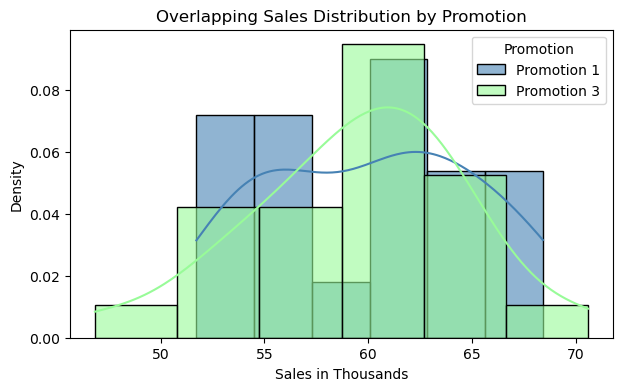

In [190]:
# Distribution of sales per promotion for medium markets
plt.figure(figsize=(7,4))
overlapping_histogram(small, ['#4682B4', '#98FB98'])
plt.show()

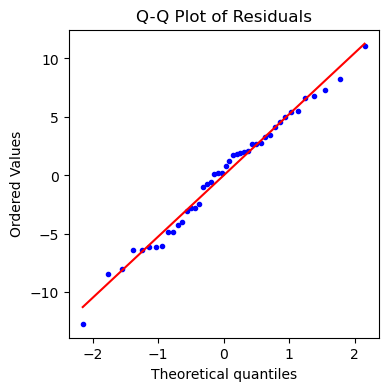

In [191]:
# Q-Q plot, residuals from ANOVA model
residuals = qqplot_residuals(small, 'Promotion', 'SalesInThousands')

In [192]:
# Shapiro-Wilk test (normality)
shapiro_func(residuals)

Shapiro-Wilk Test
   W-statistic: 0.9867185354232788
   p-value: 0.8864317536354065 (>0.05)
Data appears to be normally distributed - normality assumption is met


In [193]:
# Levene's test (homoscedasticity)
levenes_func(small)

Levene's Test
   F Statistic: 0.13415994034629944
   p-value: 0.7159959568607984 (>0.05)
Variances appear homogeneous across groups - homogeneity assumption is met


Because the normality and homogeneity assumptions are met and I am only comparing two groups, I will use a Student's t-test.

In [194]:
compare_two_means(small, 'Promotion', 'SalesInThousands', 1, 3, "Student's t-test")

Independent t-test result for Promotion 1 vs 3
T-Statistic: 0.41385419784316163
p-value: 0.6810867067433423
No significant difference between the two groups.


## Conclusion 
Through this analysis, I investigated whether sales significantly differed between various marketing promotions at fast-food locations. My initial results suggest that promotions 1 and 3 perform better than promotion 2 overall. I then looked at whether the performance of promotions 1 and 3 differed between market size. I found that promotion 1 tends to perform better in medium markets, while there was not a signficant difference in sales between promotion 1 and 3 in small and large markets.

Therefore, I suggest ending the use of promotion 2 in the fast-food chain. In order to maximise sales, I recommend running promotion 1 in medium markets. When choosing between promotions 1 and 3 for small and large markets, it would be beneficial to select the option that minimses resources spent on implementing the promotion to maximise cost efficiency, as the performance of the promotions is comparable. Further analysis could investigate whether other factors, such as customer demographics or seasonality of sales influences the effectiveness of these promotions.